# 3. Интеграция с MLflow

1. Настройте MLflow Tracking Server:

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-
root ./artifacts --host 0.0.0.0 --port 5000

2. Реализуйте полный жизненный цикл модели:
- Обучение с логированием параметров и метрик
- Регистрация в Model Registry
- Переход в Production

In [2]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feast import FeatureStore

In [9]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Hospital_Readmission_Prediction")

2025-11-19 16:36:16 WARNI [urllib3.connectionpool] Retrying (Retry(total=6, connect=6, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C9783714E0>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=Hospital_Readmission_Prediction
2025-11-19 16:36:22 WARNI [urllib3.connectionpool] Retrying (Retry(total=5, connect=5, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C978372950>: Failed to establish a new connection: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=Hospital_Readmission_Prediction
2025-11-19 16:36:32 WARNI [urllib3.connectionpool] Retrying (Retry(total=4, conn

<Experiment: artifact_location='file:///C:/Users/ISeven/Desktop/big-data/ml-production-lab4/artifacts/1', creation_time=1763545011911, experiment_id='1', last_update_time=1763545011911, lifecycle_stage='active', name='Hospital_Readmission_Prediction', tags={}>

In [3]:
store = FeatureStore(repo_path="../2/hospital_readmissions/feature_repo")

In [4]:
df_features = pd.read_parquet('../2/hospital_readmissions/feature_repo/data/patient_features.parquet')
df_features.head()

,patient_id,age,cholesterol,bmi,medication_count,length_of_stay,systolic_bp,diastolic_bp,gender,diabetes,...,multiple_conditions,age_medication_interaction,bmi_cholesterol_interaction,cardiovascular_risk,treatment_intensity,high_cholesterol,high_bmi,extended_stay,event_timestamp,created_timestamp
0,1,74,240,31.5,5,1,130,72,Other,Yes,...,1,370,7560.0,5.650,5,1,1,0,2025-11-19 16:28:55.894147,2025-11-19 16:28:55.894147
1,2,46,292,36.3,4,3,120,92,Female,No,...,0,184,10599.6,6.290,12,1,1,0,2025-11-19 16:28:55.894147,2025-11-19 16:28:55.894147
2,3,89,153,30.3,1,1,135,78,Other,No,...,1,89,4635.9,5.145,1,0,1,0,2025-11-19 16:28:55.894147,2025-11-19 16:28:55.894147
3,4,84,153,31.5,3,10,123,80,Female,No,...,1,252,4819.5,5.145,30,0,1,1,2025-11-19 16:28:55.894147,2025-11-19 16:28:55.894147
4,5,32,205,18.4,6,4,135,84,Other,No,...,1,192,3772.0,4.215,24,1,0,0,2025-11-19 16:28:55.894147,2025-11-19 16:28:55.894147


In [12]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   patient_id                   30000 non-null  int64         
 1   age                          30000 non-null  int64         
 2   cholesterol                  30000 non-null  int64         
 3   bmi                          30000 non-null  float64       
 4   medication_count             30000 non-null  int64         
 5   length_of_stay               30000 non-null  int64         
 6   systolic_bp                  30000 non-null  int64         
 7   diastolic_bp                 30000 non-null  int64         
 8   gender                       30000 non-null  object        
 9   diabetes                     30000 non-null  object        
 10  hypertension                 30000 non-null  object        
 11  discharge_destination        30000 non-nu

In [13]:
features_to_drop = ['patient_id', 'event_timestamp', 'created_timestamp', 'readmitted_30_days']

# только фичи для модели
ml_features = [col for col in df_features.columns if col not in features_to_drop]

print("Фичи для ML модели:")
for i, feature in enumerate(ml_features, 1):
    print(f"  {i:2d}. {feature}")

X = df_features[ml_features]
y = df_features['readmitted_30_days']

print(f"\nX shape: {X.shape}, y shape: {y.shape}")

Фичи для ML модели:
   1. age
   2. cholesterol
   3. bmi
   4. medication_count
   5. length_of_stay
   6. systolic_bp
   7. diastolic_bp
   8. gender
   9. diabetes
  10. hypertension
  11. discharge_destination
  12. bp_ratio
  13. bmi_category
  14. age_group
  15. high_bp_high_chol
  16. multiple_conditions
  17. age_medication_interaction
  18. bmi_cholesterol_interaction
  19. cardiovascular_risk
  20. treatment_intensity
  21. high_cholesterol
  22. high_bmi
  23. extended_stay

X shape: (30000, 23), y shape: (30000,)


In [14]:
numeric_features = []
categorical_features = []

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Числовые фичи:")
print(numeric_features)
print(f"\nКатегориальные фичи:")
print(categorical_features)

Числовые фичи:
['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'systolic_bp', 'diastolic_bp', 'bp_ratio', 'high_bp_high_chol', 'multiple_conditions', 'age_medication_interaction', 'bmi_cholesterol_interaction', 'cardiovascular_risk', 'treatment_intensity', 'high_cholesterol', 'high_bmi', 'extended_stay']

Категориальные фичи:
['gender', 'diabetes', 'hypertension', 'discharge_destination', 'bmi_category', 'age_group']


In [ ]:
X_processed = X.copy()

binary_mapping = {'Yes': 1, 'No': 0}
if 'diabetes' in X_processed.columns:
    X_processed['diabetes'] = X_processed['diabetes'].map(binary_mapping)
if 'hypertension' in X_processed.columns:
    X_processed['hypertension'] = X_processed['hypertension'].map(binary_mapping)

# OneHot encoding для остальных категориальных фич
categorical_to_encode = [col for col in categorical_features if col not in ['diabetes', 'hypertension']]

if categorical_to_encode:
    X_processed = pd.get_dummies(X_processed, columns=categorical_to_encode, prefix=categorical_to_encode)

print(f"После преобразования: {X_processed.shape}")
print("Новые колонки:")
print(X_processed.columns.tolist())

После преобразования: (30000, 34)
Новые колонки:
['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'systolic_bp', 'diastolic_bp', 'diabetes', 'hypertension', 'bp_ratio', 'high_bp_high_chol', 'multiple_conditions', 'age_medication_interaction', 'bmi_cholesterol_interaction', 'cardiovascular_risk', 'treatment_intensity', 'high_cholesterol', 'high_bmi', 'extended_stay', 'gender_Female', 'gender_Male', 'gender_Other', 'discharge_destination_Home', 'discharge_destination_Nursing_Facility', 'discharge_destination_Rehab', 'bmi_category_Underweight', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'age_group_Young', 'age_group_Adult', 'age_group_Middle', 'age_group_Senior', 'age_group_Elderly']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Данные разделены:")
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Баланс классов в train: {y_train.value_counts(normalize=True)}")

Данные разделены:
Train: (24000, 34)
Test: (6000, 34)
Баланс классов в train: readmitted_30_days
No     0.877542
Yes    0.122458
Name: proportion, dtype: float64


In [ ]:
import os

reference_data_full = pd.concat([X_train, y_train], axis=1)
current_data_full = pd.concat([X_test, y_test], axis=1)

os.makedirs('monitoring/data', exist_ok=True)

reference_data_full.to_parquet('monitoring/data/reference_data.parquet')
current_data_full.to_parquet('monitoring/data/current_data.parquet')

In [ ]:
def train_and_log_model(model, model_name, params, X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(params)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        
        mlflow.log_metrics({
            "auc": auc,
            "accuracy": accuracy
        })
        
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.set_tags({
            "project": "hospital_readmission",
            "model_type": model_name,
            "data_version": "1.0"
        })
        
        print(f"{model_name}: AUC={auc:.4f}, Accuracy={accuracy:.4f}")
        
        return model, auc, mlflow.active_run().info.run_id

3. Реализуйте сравнение версий:

In [29]:
models_to_train = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {"C": 1.0, "max_iter": 1000, "random_state": 42}
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, n_estimators=100),
        "params": {"n_estimators": 100, "max_depth": 10, "random_state": 42}
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.01),
        "params": {"n_estimators": 100, "learning_rate": 0.01, "random_state": 42}
    }
}

results = {}
for model_name, config in models_to_train.items():
    model, auc, run_id = train_and_log_model(
        config["model"],
        model_name,
        config["params"],
        X_train, X_test, y_train, y_test
    )
    results[model_name] = {"model": model, "auc": auc, "run_id": run_id}

print("\nОбучение завершено!")

c:\Users\ISeven\Desktop\big-data\ml-production-lab4\venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/11/19 17:37:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/19 17:37:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression: AUC=0.5570, Accuracy=0.8775
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/1/runs/59d3a0a011944a83a243426affa08936
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/19 17:37:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/19 17:37:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest: AUC=0.5473, Accuracy=0.8775
🏃 View run RandomForest at: http://localhost:5000/#/experiments/1/runs/1c26d05e93364ab9b507cf1344b490a1
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/19 17:37:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/19 17:37:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoosting: AUC=0.5716, Accuracy=0.8775
🏃 View run GradientBoosting at: http://localhost:5000/#/experiments/1/runs/59683a2c31a749a4aeee1c135cb30e41
🧪 View experiment at: http://localhost:5000/#/experiments/1

Обучение завершено!


In [30]:
client = MlflowClient()

# лучшая модель по AUC
best_model_name = max(results, key=lambda x: results[x]["auc"])
best_run_id = results[best_model_name]["run_id"]
best_auc = results[best_model_name]["auc"]

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"AUC: {best_auc:.4f}")
print(f"Run ID: {best_run_id}")

model_uri = f"runs:/{best_run_id}/model"
registered_model = mlflow.register_model(model_uri, "HospitalReadmissionModel")

print(f"Модель зарегистрирована: {registered_model.name} v{registered_model.version}")

Successfully registered model 'HospitalReadmissionModel'.
2025/11/19 17:38:31 WARNING mlflow.tracking._model_registry.fluent: Run with id 59683a2c31a749a4aeee1c135cb30e41 has no artifacts at artifact path 'model', registering model based on models:/m-ec9b3a72e2f14d5191da8ca56984e3f8 instead


ЛУЧШАЯ МОДЕЛЬ: GradientBoosting
AUC: 0.5716
Run ID: 59683a2c31a749a4aeee1c135cb30e41


2025/11/19 17:38:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HospitalReadmissionModel, version 1


Модель зарегистрирована: HospitalReadmissionModel v1


Created version '1' of model 'HospitalReadmissionModel'.


4. Добавьте валидацию перед деплоем:

In [33]:
client.transition_model_version_stage(
    name="HospitalReadmissionModel",
    version=registered_model.version,
    stage="Staging"
)

print(f"Модель v{registered_model.version} переведена в Staging")

def validate_model(model, X_test, y_test, threshold_auc=0.55):
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Валидация модели:")
    print(f"  AUC: {auc:.4f} (требуется > {threshold_auc})")
    print(f"  Accuracy: {accuracy:.4f}")
    
    if auc < threshold_auc:
        raise ValueError(f"Модель не проходит валидацию: AUC={auc:.4f} < {threshold_auc}")
    
    print("✅ Модель прошла валидацию!")
    return auc, accuracy

try:
    best_model = results[best_model_name]["model"]
    auc_val, acc_val = validate_model(best_model, X_test, y_test)
    
    client.transition_model_version_stage(
        name="HospitalReadmissionModel",
        version=registered_model.version,
        stage="Production"
    )
    print(f"✅ Модель v{registered_model.version} переведена в Production!")
    
except ValueError as e:
    print(f"❌ {e}")
    print("Модель остается в Staging для доработки")

Модель v1 переведена в Staging
Валидация модели:
  AUC: 0.5716 (требуется > 0.55)
  Accuracy: 0.8775
✅ Модель прошла валидацию!
✅ Модель v1 переведена в Production!


C:\Users\ISeven\AppData\Local\Temp\ipykernel_3720\729414891.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
C:\Users\ISeven\AppData\Local\Temp\ipykernel_3720\729414891.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


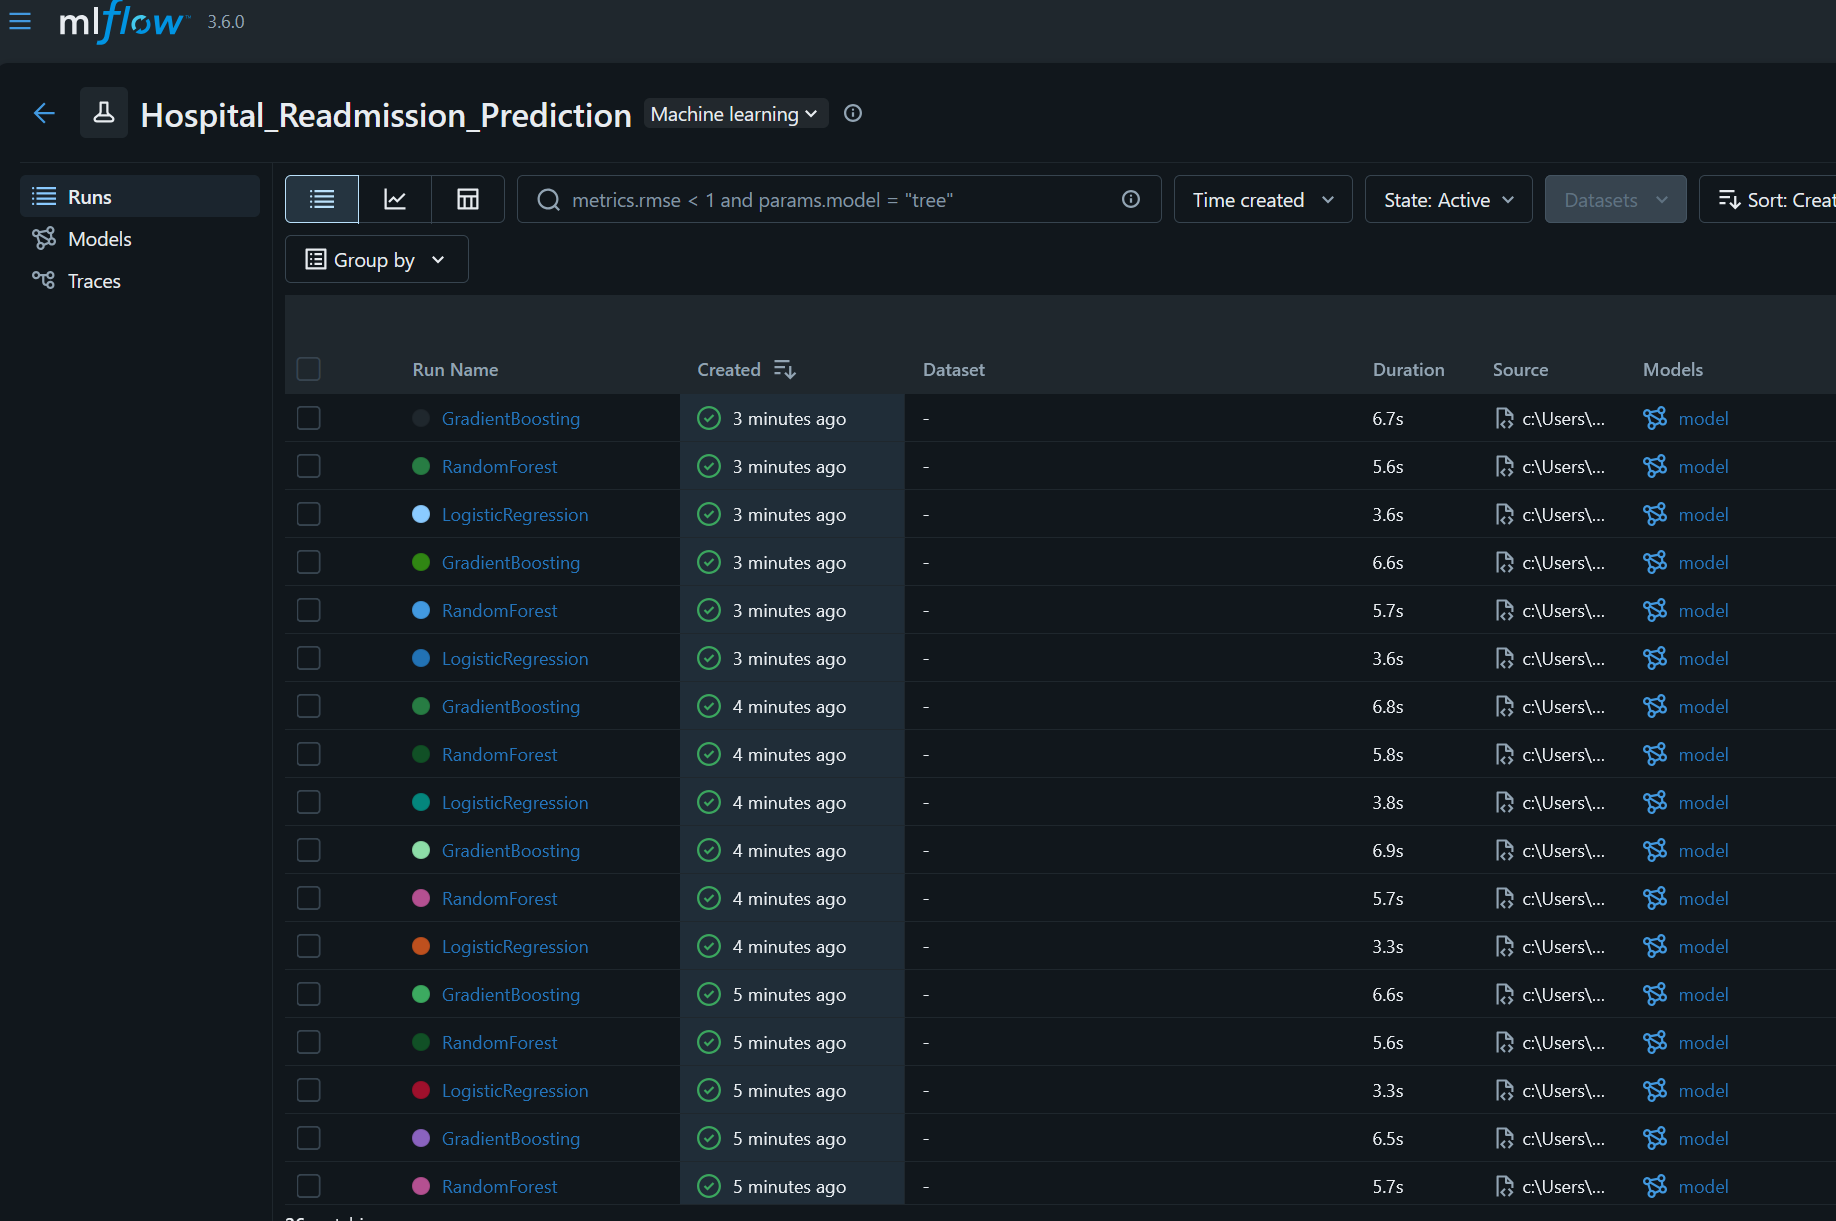

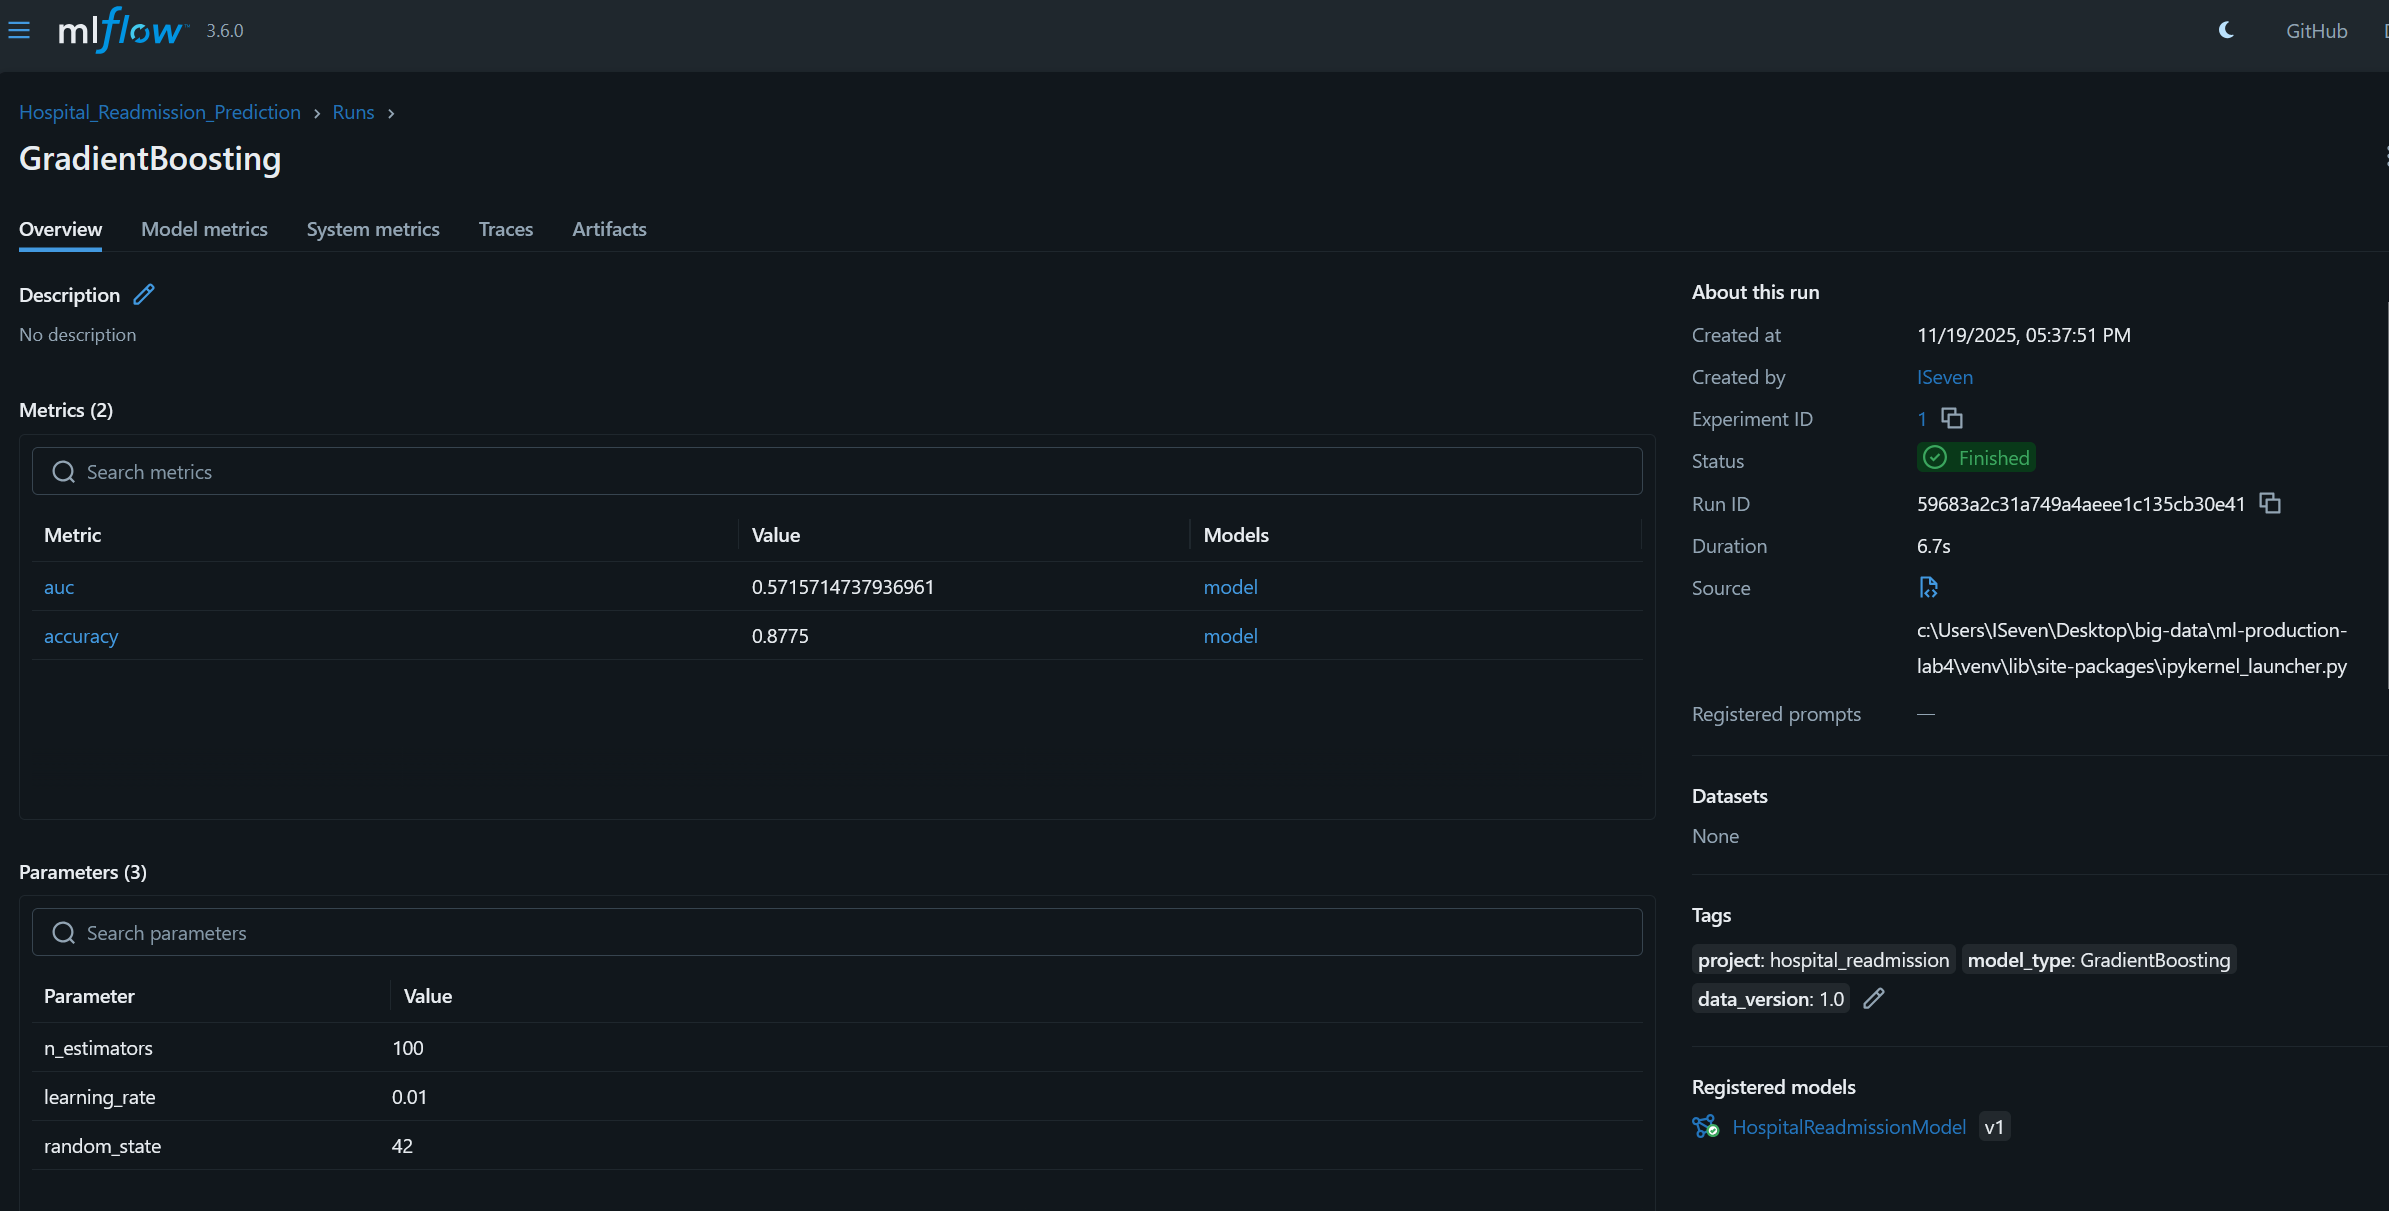